In [1]:
from heterogeneous_model import *
from sparseness_expansion import *
from IPython import display
display.set_matplotlib_formats('svg')
from scipy.stats import norm
from scipy import integrate

In [2]:
from tqdm.notebook import tqdm

Figures to be included in this section:
ASYMMETRIC MODALITIES
1. P >> K, Histogram and similarity matrix for small $p_{1}$
2. P >> K, Histogram and similarity matrix for $p_{1} \rightarrow 1$
3. P >> K, Theory and simulation for $\mathcal{C}$ term (Part 3)
4. P >> K, E-value spectrum for different values of $p_{1}$ (Part 4)
5. P >>K, Ternary plot of readout error
6. $\Delta \xi >> \Delta \phi$, Ternary plot

## 1. Histogram and similarity matrix for $p_{1} \rightarrow 1$

In [3]:
gauss_uncoup = lambda y,x: (1/(2*np.pi*np.sqrt(1 - (1/2)**(2))))\
                                        *np.exp(-(1./(2*(1 - (1/2)**(2))))*(x**(2) + y**(2) - 2*x*y*(1/2)))

In [4]:
def function_H(T):
    return 1-norm.cdf(T)

def function_in_G(h,x,T):
    
    return np.exp(-h**2/2)*function_H( ((1-x)*h-T) / np.sqrt(x*(2-x)) )/np.sqrt(2*np.pi)

def function_G(delta_s,f,T):
    
    Int_res, err = integrate.quad(function_in_G,T,np.inf,args=(delta_s,T))
    
    return Int_res/(f*(1-f))

In [5]:
def function_in_I(h1,h2,delta):
    
    return np.exp( -0.5*h1**2 - 0.5*h2**2 + 0.5*(1-delta)*h1*h2 ) / (2*np.pi)
    
def function_I(T,delta):
    
    T_delta = T / np.sqrt(1-0.25*(1-delta)**2)
    
    
    Int_res, err = integrate.dblquad(function_in_I, T_delta, np.inf, lambda h1: T_delta, lambda h1: np.inf, args=(delta,))
    
    return Int_res*np.sqrt(1-0.25*(1-delta)**2)

In [6]:
#One Gaussian peaks - same gamma different mu
def compute_peak_q2(p1,p3,f, delta_sigma, th):
    f2 = f*(1-f)*(1-function_G(delta_sigma,f,th))
    peak_eff_q2 = p1*f2 + p3*(function_I(th, delta_sigma)-f**2)
    return peak_eff_q2

#Other Gaussian peak - same mu different gamma
def compute_peak_q1(p2,p3,f, delta_phi, th):
    f2 = f*(1-f)*(1-function_G(delta_phi,f,th))
    peak_eff_q1 = p2*f2 + p3*(function_I(th, delta_phi)-f**2)
    return peak_eff_q1

In [7]:
N=100
H=2100
P=100
K=5
ds=0.1
dc=0.1
th=0.8
Peff = P*K
rand_int = np.random.randint(Peff)

p1=0.6
rem = 1-p1
p2 = rem/2
p3=p2

f=erf1(th)

o_stats=np.array([])
for i in tqdm(range(10)):
    h_small,h_test_small = generate_hetergeneous(H,N,P,K,p1,p2,p3,d_stim=ds,d_cont=dc)
    o_small = 0.5*(np.sign(h_small-th)+1) - f
    o_small_test = 0.5*(np.sign(h_test_small-th)+1) - f
    cov_small = (1/H)*np.matmul(o_small.T,o_small_test)
    o1 = cov_small.reshape(-1)
    o_stats=np.concatenate((o_stats,o1))

In [8]:
Peff = P*K
q1 = ((K-1)/(Peff-1))
q2 = ((P-1)/(Peff-1))
peak_eff_q1 = compute_peak_q1(p1,p3,f, ds, th)
peak_eff_q2 = compute_peak_q2(p2,p3,f, dc, th)

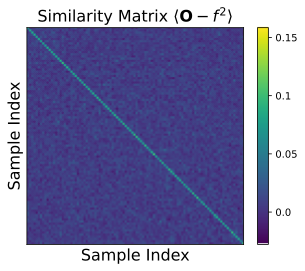

In [9]:
fig = plt.figure(figsize=(5,4))
plt.title(r'Similarity Matrix $\langle\mathbf{O}-f^2\rangle$', fontsize=16)
plt.imshow(cov_small)

#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("left", size="5%", pad=1.05)
#plt.tight_layout()
cbar = plt.colorbar()
cbar.set_ticks([0, 0.05, 0.10, 0.15])
cbar.set_ticklabels([0.00, 0.05, 0.10, 0.15])
plt.xticks([])
plt.yticks([])
plt.xlabel('Sample Index', fontsize=16)
plt.ylabel('Sample Index', fontsize=16)
plt.savefig('load_hetero_histogram_similarity_matrix.png',transparent=True,dpi=600,bbox_inches='tight')
plt.show()

/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


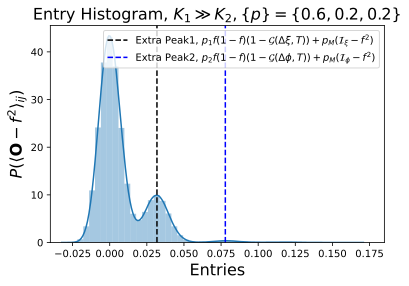

In [10]:
fig = plt.figure(figsize=(6,4))
ax2 = fig.add_subplot(111)
ax2.set_title(r'Entry Histogram, $K_1\gg K_2, \{p\} = \{0.6,0.2,0.2\}$',fontsize=16)
sns.distplot(o_stats, norm_hist=True)
ax2.axvline(peak_eff_q2,color='black',linestyle='--',label=r'Extra Peak1, $p_{1}f(1-f)(1-\mathcal{G}(\Delta\xi,T)) + p_{M}(\mathcal{I}_{\xi}-f^{2})$')
ax2.axvline(peak_eff_q1,color='blue',linestyle='--',label=r'Extra Peak2, $p_{2}f(1-f)(1-\mathcal{G}(\Delta\phi,T)) + p_{M}(\mathcal{I}_{\phi}-f^{2})$')
ax2.set_xlabel(r'Entries',fontsize=16)
ax2.set_ylabel(r'$P(\langle\mathbf{O}-f^2\rangle_{ij})$',fontsize=16)
ax2.set_xlim(-0.04,0.185)
ax2.legend(loc='upper right')
plt.savefig('load_hetero_histogram_cov_m.png',transparent=True,dpi=600,bbox_inches='tight')
plt.show()

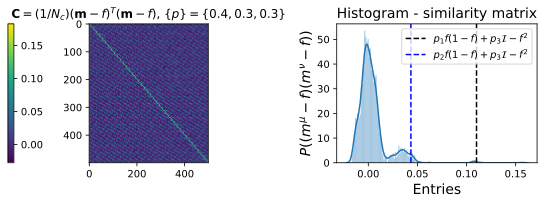

In [33]:
##IMSHOW OF H
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display
display.set_matplotlib_formats('svg')
path_fig = 'figures_section5'

fig = plt.figure(figsize=(8,3))
ax1 = fig.add_subplot(121)
ax1.set_title(r'$\mathbf{C}  = (1/N_{c})(\mathbf{m} - f)^{T}(\mathbf{m} - f)$, $\{ p \} = \{ 0.4,0.3,0.3 \}$')
im1 = ax1.imshow(cov_o_small,aspect='auto')
ax2 = fig.add_subplot(122)
ax2.set_title(r'Histogram - similarity matrix',fontsize=14)
sns.distplot(o1,bins=150)
ax2.axvline(peak_eff_q2,color='black',linestyle='--',label=r'$p_{1}f(1-f) + p_{3}\mathcal{I}-f^{2}$')
ax2.axvline(peak_eff_q1,color='blue',linestyle='--',label=r'$p_{2}f(1-f) + p_{3}\mathcal{I}-f^{2}$')
ax2.set_xlabel(r'Entries',fontsize=14)
ax2.set_ylabel(r'$P((m^{\mu}-f) (m^{\nu}-f))$',fontsize=14)
ax2.legend()
divider = make_axes_locatable(ax1)
cax = divider.append_axes("left", size="5%", pad=1.05)
plt.tight_layout()
plt.colorbar(im1,cax=cax)
plt.savefig('{}/histogram_cov_m_p1small.png'.format(path_fig),transparent=True,dpi=200,bbox_inches='tight')
plt.show()

## 2. Histogram and similarity matrix for $p_{1} \rightarrow 1$

In [11]:
N=100
H=2100
P=100
K=5
ds=0.1
dc=0.1
th=0.8
Peff = P*K
rand_int = np.random.randint(Peff)

p1=1.0
rem = 1-p1
p2 = rem/2
p3=p2

f=erf1(th)

o_stats=np.array([])
for i in tqdm(range(10)):
    h_small,h_test_small = generate_hetergeneous(H,N,P,K,p1,p2,p3,d_stim=ds,d_cont=dc)
    o_small = 0.5*(np.sign(h_small-th)+1) - f
    o_small_test = 0.5*(np.sign(h_test_small-th)+1) - f
    cov_small = (1/H)*np.matmul(o_small.T,o_small_test)
    o1 = cov_small.reshape(-1)
    o_stats=np.concatenate((o_stats,o1))

In [12]:
Peff = P*K
q1 = ((K-1)/(Peff-1))
q2 = ((P-1)/(Peff-1))
peak_eff_q1 = compute_peak_q1(p1,p3,f, ds, th)
peak_eff_q2 = compute_peak_q2(p2,p3,f, dc, th)

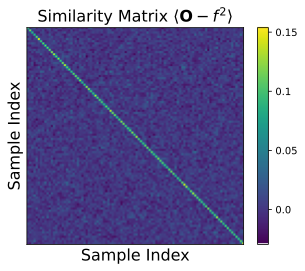

In [13]:
fig = plt.figure(figsize=(5,4))
plt.title(r'Similarity Matrix $\langle\mathbf{O}-f^2\rangle$', fontsize=16)
plt.imshow(cov_small)

#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("left", size="5%", pad=1.05)
#plt.tight_layout()
cbar = plt.colorbar()
cbar.set_ticks([0, 0.05, 0.10, 0.15])
cbar.set_ticklabels([0.00, 0.05, 0.10, 0.15])
plt.xticks([])
plt.yticks([])
plt.xlabel('Sample Index', fontsize=16)
plt.ylabel('Sample Index', fontsize=16)
plt.savefig('load_pure_histogram_similarity_matrix.png',transparent=True,dpi=600,bbox_inches='tight')
plt.show()

/opt/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


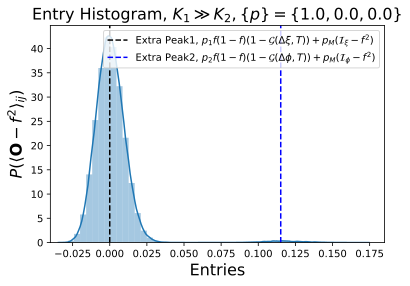

In [14]:
fig = plt.figure(figsize=(6,4))
ax2 = fig.add_subplot(111)
ax2.set_title(r'Entry Histogram, $K_1\gg K_2, \{p\} = \{1.0,0.0,0.0\}$',fontsize=16)
sns.distplot(o_stats, norm_hist=True)
ax2.axvline(peak_eff_q2,color='black',linestyle='--',label=r'Extra Peak1, $p_{1}f(1-f)(1-\mathcal{G}(\Delta\xi,T)) + p_{M}(\mathcal{I}_{\xi}-f^{2})$')
ax2.axvline(peak_eff_q1,color='blue',linestyle='--',label=r'Extra Peak2, $p_{2}f(1-f)(1-\mathcal{G}(\Delta\phi,T)) + p_{M}(\mathcal{I}_{\phi}-f^{2})$')
ax2.set_xlabel(r'Entries',fontsize=16)
ax2.set_ylabel(r'$P(\langle\mathbf{O}-f^2\rangle_{ij})$',fontsize=16)
ax2.set_xlim(-0.04,0.185)
ax2.legend(loc='upper right')
plt.savefig('load_pure_histogram_cov_m.png',transparent=True,dpi=600,bbox_inches='tight')
plt.show()

## 3. Theory and simulation for C term

In [44]:
def compute_part3(f,q1,q2,p1,p2,p3,ds,dc):
    size1 = erf_full(th,ds,f)
    size2 = erf_full(th,dc,f)
    
    f_one_minus = f*(1-f)
    
    #Peaks
    p_xi = (1/2)*(1 - ds)
    p_phi = (1/2)*(1 - dc)
    
    #Intergral limits
    sqrt_xi = np.sqrt(1 - p_xi**(2))
    sqrt_phi = np.sqrt(1 - p_phi**(2))
    t_xi = th/(sqrt_xi)
    t_phi = th/(sqrt_phi)
    
    #Get the two dimensional integrals
    i_phi = two_dim_i_integral(t_phi,p_phi)
    i_xi = two_dim_i_integral(t_xi,p_xi)
    
    r_xi = f_one_minus*(1-size1)
    r_phi = f_one_minus*(1-size2)
    r_mixed = (q1)*(sqrt_xi)*(i_xi) + (q2)*(sqrt_phi)*(i_phi)  + (1-q1-q2)*f**(2)
    #print("q1+q2",q1+q2)
    #print("r_mixed",r_mixed)

    corr_m = p1*(f**(2) + q1*r_xi) + p2*(f**(2) + q2*r_phi) + p3*r_mixed
    diff = f**(2) - corr_m
    
    rat = (2*f - 1)**(2) / ((f*(1-f))**(2))
    
    f_term = - rat*(diff)
    
    return f_term

def compute_part3_compare(th,P,K,ds=0.1,dc=0.1):
    f = erf1(th)
    Peff = int(P*K)
    
    q1 = ((K-1)/(Peff-1))
    q2 = ((P-1)/(Peff-1))
    
    #Limit one, p1 --> 1
    p1_1 = 1.0
    diff1 = 1-p1_1
    p2_1 = diff1/2
    p3_1 = p2_1
    
    #print("p's 1",p1_1,p2_1,p3_1)
    
    f_term1 = compute_part3(f,q1,q2,p1_1,p2_1,p3_1,ds,dc)
    
    #Limit one, p2 --> 1
    p2_2 = 1.0
    diff2 = 1-p2_2
    p1_2 = diff2/2
    p3_2 = p1_2
    
    #print("p's 2",p1_2,p2_2,p3_2)
    
    f_term2 = compute_part3(f,q1,q2,p1_2,p2_2,p3_2,ds,dc)
    
    #Limit one, p3 --> 1
    p3_3 = 1.0
    diff3 = 1-p3_3
    p2_3 = diff3/2
    p1_3 = p2_3
    
    #print("p's 3",p1_3,p2_3,p3_3)
    
    f_term3 = compute_part3(f,q1,q2,p1_3,p2_3,p3_3,ds,dc)
    
    return f_term1, f_term2, f_term3   

In [2]:
# Use Minhuan's Codes to generate curves
from scipy.stats import norm
from scipy import integrate

def function_H(T):
    return 1-norm.cdf(T)

def function_in_G(h,x,T):
    return np.exp(-h**2/2)*function_H( ((1-x)*h-T) / np.sqrt(x*(2-x)) )/np.sqrt(2*np.pi)

def function_G(delta_s,f,T):
    Int_res, err = integrate.quad(function_in_G,T,np.inf,args=(delta_s,T))    
    return Int_res/(f*(1-f))

def function_in_I(h1,h2,delta):    
    return np.exp( -0.5*h1**2 - 0.5*h2**2 + 0.5*(1-delta)*h1*h2 ) / (2*np.pi)
    
def function_I(T,delta):    
    T_delta = T / np.sqrt(1-0.25*(1-delta)**2)
    Int_res, err = integrate.dblquad(function_in_I, T_delta, np.inf, lambda h1: T_delta, lambda h1: np.inf, args=(delta,))  
    return Int_res

def s_delta(delta):  
    return np.sqrt(1 - 0.25*(1-delta)**2)

def q1_func(f,T,delta_sigma):
    return f-f*(1-f)*function_G(delta_sigma,f,T)

def q2_func(f,T,delta_eta):
    return f-f*(1-f)*function_G(delta_eta,f,T)

def q_func(p1,p2,p3,f,T,delta_sigma,delta_eta):
    delta_mix = (delta_sigma + delta_eta) / 2.
    delta_m = p1*function_G(delta_sigma,f,T) + p2*function_G(delta_eta,f,T) +  p3*function_G(delta_mix,f,T)
    return f - delta_m*f*(1-f)

def part3_func(Nc,N,M,P,K,p1,p2,p3,f,T,q1,q2,delta_sigma,delta_eta):
    uni_term = Nc*(P*K-1) * f**2 * (1-f)**2
    excess_term1 = Nc*(2*f-1)**2 * ( (K-1)*p1*(q1-f**2) + (P-1)*p2*(q2-f**2) )   
    excess_term2 = Nc*(2*f-1)**2 * p3 * (K-1) * s_delta(delta_sigma) * function_I(T, delta_sigma)  
    excess_term3 = Nc*(2*f-1)**2 * p3 * (P-1) * s_delta(delta_eta) * function_I(T, delta_eta)
    excess_term4 = Nc*(2*f-1)**2 * p3 * f**2 * (P+K-2)
    return uni_term + excess_term1 + excess_term2 + excess_term3 - excess_term4

def compute_termC(f,Nc,N,M,P,K,p1,p2,p3,ds,dc):
    T = norm.ppf(1-f)
    q1 = q1_func(f,T,ds)
    q2 = q2_func(f,T,dc)
    q = q_func(p1,p2,p3,f,T,ds,dc) 
    part3 = part3_func(Nc,N,M,P,K,p1,p2,p3,f,T,q1,q2,ds,dc)
    return part3/(f**2*(1-f)**2*Nc*P*K)- 1


def compute_termC_compare(th,Nc,N,M,P,K,ds=0.1,dc=0.1):
    f = erf1(th)
    
    #Limit one, p1 --> 1
    p1_1 = 1.0
    diff1 = 1-p1_1
    p2_1 = diff1/2
    p3_1 = p2_1
    
    #print("p's 1",p1_1,p2_1,p3_1)
    
    f_term1 = compute_termC(f,Nc,N,M,P,K,p1_1,p2_1,p3_1,ds,dc)
    
    #Limit one, p2 --> 1
    p2_2 = 1.0
    diff2 = 1-p2_2
    p1_2 = diff2/2
    p3_2 = p1_2
    
    #print("p's 2",p1_2,p2_2,p3_2)
    
    f_term2 = compute_termC(f,Nc,N,M,P,K,p1_2, p2_2, p3_2,ds,dc)
    
    #Limit one, p3 --> 1
    p3_3 = 1.0
    diff3 = 1-p3_3
    p2_3 = diff3/2
    p1_3 = p2_3
    
    #print("p's 3",p1_3,p2_3,p3_3)
    
    f_term3 = compute_termC(f,Nc,N,M,P,K,p1_3, p2_3, p3_3,ds,dc)
    
    return f_term1, f_term2, f_term3

In [45]:
##Aymmetric modalities
#Calculate C
P=100
K=5
Peff = P*K
d_xi=0.1
d_phi=0.1
p1=1.0
diff=1-p1
p3=diff/2
p2=p3

# p2=1.0
# diff=1-p2
# p1 = diff/2
# p3=p1

th=2.2
q1 = (K-1)/(Peff-1)
q2 = (P-1)/(Peff-1)
f = erf1(th)
print("f is",f)
c = compute_part3(f,q1,q2,p1,p3,p2,ds=d_xi,dc=d_phi)
print("C term",c)

f is 0.013903447513497518
C term 0.30570905451717223


In [46]:
th_list = np.linspace(0,3.1,20)
P=100
K=5
f1_list = np.zeros(len(th_list))
f2_list = np.zeros(len(th_list))
f3_list = np.zeros(len(th_list))
cods_list = np.zeros(len(th_list))

for i,th in enumerate(th_list):
    f = erf1(th)
    f1,f2,f3 = compute_part3_compare(th,P,K)
    f1_list[i] = f1
    f2_list[i] = f2
    f3_list[i] = f3
    cods_list[i] = f

In [8]:
# use minhuan's codes
th_list = np.linspace(0,3.1,20)
P=80
#K=int(prod/P)
K=5
Nc=2100
d_xi=0.1
d_phi=0.1
N=100
M=100
f1_list = np.zeros(len(th_list))
f2_list = np.zeros(len(th_list))
f3_list = np.zeros(len(th_list))
cods_list = np.zeros(len(th_list))

for i,th in enumerate(tqdm(th_list)):
    f = erf1(th)
    f1,f2,f3 = compute_termC_compare(th,Nc,N,M,P,K, ds=d_xi,dc=d_phi)
    f1_list[i] = f1
    f2_list[i] = f2
    f3_list[i] = f3
    cods_list[i] = f

In [9]:
# Use Arvin's experimental codes
H=2100
N=100
ds=0.1
dc=0.1

#Limit one, p1 --> 1
p1_1 = 1.0
diff1 = 1-p1_1
p2_1 = diff1/2
p3_1 = p2_1

#Limit one, p2 --> 1
p2_2 = 1.0
diff2 = 1-p2_2
p1_2 = diff2/2
p3_2 = p1_2


#Limit one, p3 --> 1
p3_3 = 1.0
diff3 = 1-p3_3
p2_3 = diff3/2
p1_3 = p2_3
    
    
h1,h_test = generate_hetergeneous(H,N,P,K,p1_1,p2_1,p3_1,d_stim=ds,d_cont=dc)
h2,h_test2 = generate_hetergeneous(H,N,P,K,p1_2,p2_2,p3_2,d_stim=ds,d_cont=dc)
h3,h_test3 = generate_hetergeneous(H,N,P,K,p1_3,p2_3,p3_3,d_stim=ds,d_cont=dc)

f1_emps = np.zeros(len(th_list))
f2_emps = np.zeros(len(th_list))
f3_emps = np.zeros(len(th_list))

def comp_corr(f,tp):
    rat = (2*f - 1)**(2) / ((f*(1-f))**(2))
    diff = tp
    c_term = rat*(diff)
    
    return c_term


for i,th in enumerate(th_list):
    f = erf1(th)
    m1 = 0.5*(np.sign(h1 - th) + 1) - f
    m1_test = 0.5*(np.sign(h_test - th) + 1) - f
    
    m2 = 0.5*(np.sign(h2 - th) + 1) - f
    m2_test = 0.5*(np.sign(h_test2- th) + 1) - f
    
    m3 = 0.5*(np.sign(h3 - th) + 1) - f
    m3_test = 0.5*(np.sign(h_test3 - th) + 1) - f
    ovs1 = []
    ovs2 = []
    ovs3 = []
    for p in range(m1.shape[1]):
        for q in range(m1.shape[1]):
            if p!=q:
                #print("p,q",p,q)
                ov1 = (1/H)*np.dot(m1[:,p],m1_test[:,q])
                ovs1.append(comp_corr(f,ov1))
                ov2 = (1/H)*np.dot(m2[:,p],m2_test[:,q])
                ovs2.append(comp_corr(f,ov2))
                ov3 = (1/H)*np.dot(m3[:,p],m3_test[:,q])
                ovs3.append(comp_corr(f,ov3))
                
                
    f1_emps[i] = np.mean(ovs1)
    f2_emps[i] = np.mean(ovs2)
    f3_emps[i] = np.mean(ovs3)

In [10]:
np.savetxt(r'cods_list.txt',cods_list,fmt='%.7f', delimiter=',')
np.savetxt(r'f_list.txt',np.vstack((f1_list,f2_list,f3_list)),fmt='%.7f', delimiter=',')
np.savetxt(r'f_emps.txt',np.vstack((f1_emps,f2_emps,f3_emps)),fmt='%.7f', delimiter=',')

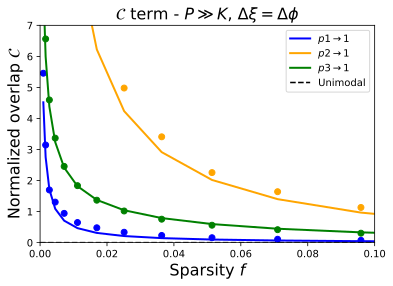

In [12]:
path4 = 'figures_section5'
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display
display.set_matplotlib_formats('svg')

fu_list = [(f*(1-f))**(2) for f in cods_list]
fig = plt.figure(figsize=[6,4])
plt.title(r'$\mathcal{C}$ term - $P\gg K$, $\Delta \xi=\Delta \phi$', fontsize=16)
plt.plot(cods_list,f1_list,'-',color='blue',label=r'$p1 \rightarrow 1$', lw=2)
plt.plot(cods_list,f1_emps,'o',color='blue')
plt.plot(cods_list,f2_list,'-',color='orange',label=r'$p2 \rightarrow 1$', lw=2)
plt.plot(cods_list,f2_emps,'o',color='orange')
plt.plot(cods_list,f3_list,'-',color='green',label=r'$p3 \rightarrow 1$', lw=2)
plt.plot(cods_list,f3_emps,'o',color='green')
#plt.plot(cods_list,fu_list,color='black',label=r'$Unimodal$')
plt.xlabel(r'Sparsity $f$',fontsize=16)
plt.ylabel(r'Normalized overlap $\mathcal{C}$',fontsize=16)
plt.xlim(0.0,0.1)
plt.ylim(0,7)
plt.axhline(0,color='black',linestyle='--',label=r'Unimodal')
plt.legend()
plt.savefig('load_correction_term_symm.png',transparent=True,dpi=600,bbox_inches='tight')
plt.show()

## 4. Eigenvalue spectrum for different values of $p_{1}$ 

In [13]:
N=100
P=80
K=5
H=2100
th=0.8

In [14]:
###Give 3 configs
p1_1 = 0.2
diff1 = 1 - p1_1
p3_1 = diff1/2
p2_1 = p3_1

p1_2 = 0.6
diff2 = 1 - p1_2
p3_2 = diff2/2
p2_2 = p3_2

p1_3 = 1.0
diff3 = 1 - p1_3
p3_3 = diff3/2
p2_3 = p3_3

In [15]:
th = 0.8
dstim=0.1
dcont=0.1
f = erf1(th)
h1,h_test1 = generate_hetergeneous(H,N,P,K,p1_1,p2_1,p3_1,d_stim=dstim,d_cont=dcont)
o1 = 0.5*(np.sign(h1 - th) + 1) - f
o1_test = 0.5*(np.sign(h_test1 - th) + 1) - f

cov1 = (1/H)*np.matmul(o1.T,o1_test)
eigs1 = LA.eigvals(cov1)

h2,h_test2 = generate_hetergeneous(H,N,P,K,p1_2,p2_2,p3_2,d_stim=dstim,d_cont=dcont)
o2 = 0.5*(np.sign(h2 - th) + 1) - f
o2_test = 0.5*(np.sign(h_test2 - th) + 1) - f

cov2 = (1/H)*np.matmul(o2.T,o2_test)
eigs2 = LA.eigvals(cov2)


h3,h_test3 = generate_hetergeneous(H,N,P,K,p1_3,p2_3,p3_3,d_stim=dstim,d_cont=dcont)
o3 = 0.5*(np.sign(h3 - th) + 1) - f
o3_test = 0.5*(np.sign(h_test3 - th) + 1) - f

cov3 = (1/H)*np.matmul(o3.T,o3_test)
eigs3 = LA.eigvals(cov3)

/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


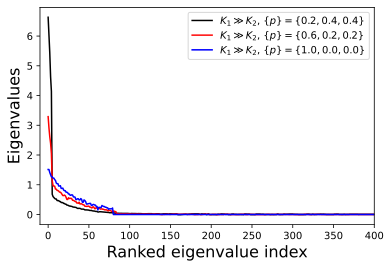

In [20]:
plt.figure(figsize=[6,4])
#plt.title(r'Comparison of eigenvalue spectrum - unimodal vs. multi-modal',fontsize=14)
plt.plot(eigs1,color='black',label=r'$K_1\gg K_2$, $\{ p \} = \{ 0.2,0.4,0.4 \}$')
plt.plot(eigs2,color='red',label=r'$K_1\gg K_2$, $\{ p \} = \{ 0.6,0.2,0.2 \}$')
plt.plot(eigs3,color='blue',label=r'$K_1\gg K_2$, $\{ p \} = \{ 1.0,0.0,0.0 \}$')
#plt.axvline(N,linestyle='--',label='$N=100$')
plt.xlabel(r'Ranked eigenvalue index',fontsize=16)
plt.ylabel(r'Eigenvalues',fontsize=16)
plt.xlim(-10,400)
plt.legend()
plt.savefig('load_comparison_eigenvalues.png',transparent=True,dpi=600,bbox_inches='tight')
plt.show()

/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/miniconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


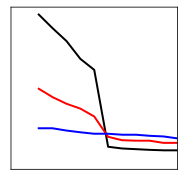

In [22]:
plt.figure(figsize=[3,3])
#plt.title(r'Comparison of eigenvalue spectrum - unimodal vs. multi-modal',fontsize=14)
plt.plot(eigs1,color='black',label=r'Unimodal', lw=2)
plt.plot(eigs2,color='red',label=r'Multimodal, $\{ p \} = \{ 0.3,0.3,0.4 \}$', lw=2)
plt.plot(eigs3,color='blue',label=r'Multimodal, $\{ p \} = \{ 0.0,0.0,1.0 \}$', lw=2)
plt.axvline(N,linestyle='--',label='$N=100$', lw=2)
#plt.xlabel(r'Ranked eigenvalue index',fontsize=16)
#plt.ylabel(r'Eigenvalues',fontsize=16)
plt.xlim(-2,10)
#plt.ylim(-0.1,0.5)
plt.xticks([])
plt.yticks([])
#plt.legend()
plt.savefig('load_comparison_eigenvalues_inner.png',transparent=True,dpi=600,bbox_inches='tight')
plt.show()

## 5. Ternary plots for asymmetric $P >> K$

In [ ]:
from tqdm import tqdm_notebook
from ternary.helpers import simplex_iterator
import ternary
from scipy.special import comb, perm

In [ ]:
n=10 # grid size
def func_run_grid_sim(n,N,H,P,K,d_xi,d_phi,th):
    Record_2= dict()


    for i,j,k in tqdm_notebook(simplex_iterator(n),total = comb(n+2,n)):

        p1 = i / float(n)
        p2 = j / float(n)
        p3 = k / float(n)
        
        #print("p values are",p1,p2,p3)

        Record_2[(i,j,k)] = hebbian_mixed_layer_heterogeneous(H,N,P,K,th,p1,p2,p3,ds=d_xi,dc=d_phi)[1]
        
    return Record_2

In [ ]:
N=100
P=80
K=5
H=2100
th=0.8
dstim=0.1
dcont=0.1
Record_3 = func_run_grid_sim(n,N,H,P,K,dstim,dcont,th)

In [ ]:
path4 = 'figures_section5'
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display
display.set_matplotlib_formats('svg')


figure, tax = ternary.figure(scale=n)
tax.heatmap(Record_3,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(10.6,9.2,r'Readout Error $\epsilon$')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$\Delta \xi = \Delta \phi = 0.1$, $P = 80$, $K = 5$',y=1)

plt.savefig('{}/comparison_readout_err_asymm.png'.format(path4),transparent=True,dpi=200,bbox_inches='tight')
plt.show()

## 6. Ternary plots for asymmetric $\Delta \xi >> \Delta \phi$

In [ ]:
N=100
P=10
K=10
H=2100
th=0.8
dstim=0.9
dcont=0.05
Record_4 = func_run_grid_sim(n,N,H,P,K,dstim,dcont,th)

In [ ]:
path4 = 'figures_section5'
from mpl_toolkits.axes_grid1 import make_axes_locatable
from IPython import display
display.set_matplotlib_formats('svg')


figure, tax = ternary.figure(scale=n)
tax.heatmap(Record_3,scale=n)
tax.boundary()
tax.left_axis_label("$p_3$",offset=0.14,fontsize=12)
tax.right_axis_label("$p_2$",offset=0.14,fontsize=12)
tax.bottom_axis_label("$p_1$",fontsize=12)

tax.gridlines(multiple = 1, color="blue")

plt.text(0,-0.5,'0.0')
plt.text(9.5,-0.5,'1.0')

plt.text(9.7,0.2,'0.0',rotation=-60)
plt.text(5.1,8.1,'1.0',rotation = -60)

plt.text(4.2,8.1,'0.0',rotation= 60)
plt.text(-0.3,0.2,'1.0',rotation = 60)


plt.text(10.6,9.2,r'Readout Error $\epsilon$')

# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')

tax.set_title(r'$\Delta \xi = 0.9$, $\Delta \phi = 0.05$, $P = K = 10$',y=1)

plt.savefig('{}/comparison_readout_err_asymm.png'.format(path4),transparent=True,dpi=200,bbox_inches='tight')
plt.show()